# Take Home Challenge 3 - Employee Retention

#### Problem Statement

#### Challenge Description

#### Data Description

#### Field Value Description

#### Observations

#### Conclusions and Recommendations

#### Analysis

In [311]:
#Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
import datetime as dt
from sklearn.cross_validation import train_test_split,cross_val_score,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score,accuracy_score,precision_score,recall_score,f1_score
from sklearn.grid_search import GridSearchCV

In [312]:
#load data
df=pd.read_csv("employee_retention_data.csv")

##### Explore data to analyze data size, data types and to identify outliers.

In [313]:
df.shape

(24702, 7)

In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [315]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [316]:
#Fix datatypes
df.employee_id=df.employee_id.astype(int)
df.company_id=df.company_id.astype(object)
df['join_date']=pd.to_datetime(df['join_date'])
df['quit_date']=pd.to_datetime(df['quit_date'])

In [317]:
df.describe(include='all')

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
count,24702.000000,24702.0,24702,24702.000000,24702.000000,24702,13510
unique,NaN,12.0,6,NaN,NaN,995,664
top,NaN,1.0,customer_service,NaN,NaN,2012-01-03 00:00:00,2015-05-08 00:00:00
freq,NaN,8486.0,9180,NaN,NaN,105,111
first,NaN,NaN,NaN,NaN,NaN,2011-01-24 00:00:00,2011-10-13 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2015-12-10 00:00:00,2015-12-09 00:00:00
mean,501604.403530,NaN,NaN,14.127803,138183.345478,NaN,NaN
std,288909.026101,NaN,NaN,8.089520,76058.184573,NaN,NaN
min,36.000000,NaN,NaN,1.000000,17000.000000,NaN,NaN
25%,250133.750000,NaN,NaN,7.000000,79000.000000,NaN,NaN


#### Count Missing Values

In [318]:
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns 

In [319]:
mis_val_table_ren_columns=missing_values_table(df)
print(mis_val_table_ren_columns)

             Missing Values  % of Total Values
employee_id               0           0.000000
company_id                0           0.000000
dept                      0           0.000000
seniority                 0           0.000000
salary                    0           0.000000
join_date                 0           0.000000
quit_date             11192          45.308072


In [320]:
df['quit_date']=df['quit_date'].replace(np.nan, "", regex=True)
df['quit_date']=pd.to_datetime(df['quit_date'])

C:\Anaconda3\lib\site-packages\pandas\core\internals.py:4782: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  comp = (nn == nn_at)


### Visualizations

#### Company ID

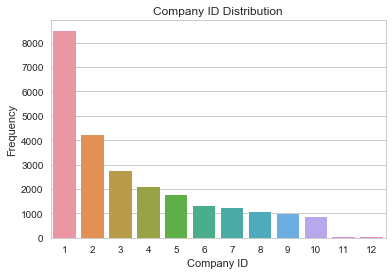

In [321]:
#Plot Company ID to view range and frequency
sns.countplot(df['company_id'])
plt.xlabel('Company ID')
plt.ylabel('Frequency')
plt.title('Company ID Distribution')
plt.show()

In [322]:
#Remove outliers - Company ID = 11,12
df=df[(df.company_id<=10)]

#### Department

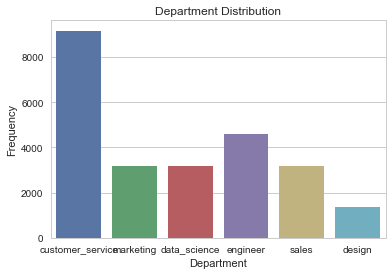

In [323]:
#Plot dept to view range and frequency
sns.countplot(df['dept'])
plt.xlabel('Department')
plt.ylabel('Frequency')
plt.title('Department Distribution')
plt.show()

#### Seniority

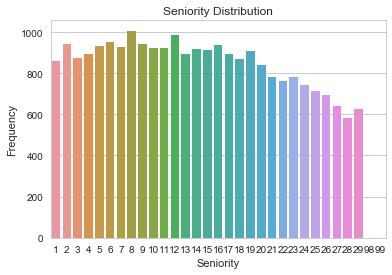

In [324]:
#Plot Seniority to view range and frequency
sns.countplot(df['seniority'])
plt.xlabel('Seniority')
plt.ylabel('Frequency')
plt.title('Seniority Distribution')
plt.show()

Seniority categories 98 and 99 are outliers. We can remove the data points before proceeding.

In [325]:
#Remove outliers - Seniority = 98,99
df=df[(df.seniority<98)]

#### Salary

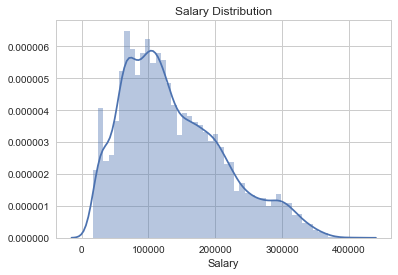

In [326]:
#Plot Salary to view distribution
sns.distplot(df['salary'])
plt.xlabel('Salary')
plt.title('Salary Distribution')
plt.show()

#### Join Date - Feature Extraction

In [327]:
#Extract info from join date to observe trends
df['join_year']=df.join_date.dt.year
df['join_month']=df.join_date.dt.month
df['join_day']=df.join_date.dt.day
df['join_week']=df.join_date.dt.week
df['join_weekday']=df.join_date.dt.weekday

#### Join Year

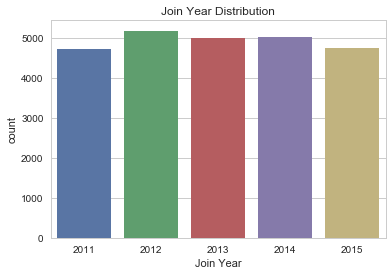

In [328]:
#Plot join_year to view distribution
sns.countplot(df['join_year'])
plt.xlabel('Join Year')
plt.title('Join Year Distribution')
plt.show()

#### Join Month

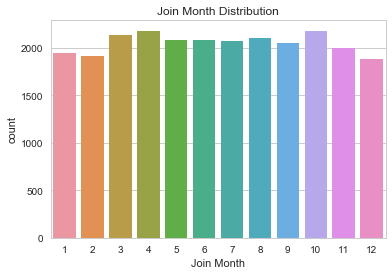

In [329]:
#Plot join_month to view distribution
sns.countplot(df['join_month'])
plt.xlabel('Join Month')
plt.title('Join Month Distribution')
plt.show()

#### Join Week

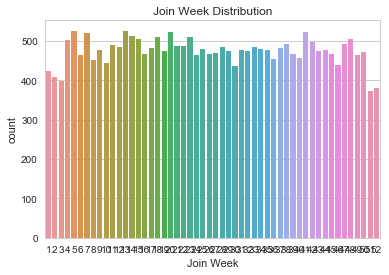

In [330]:
#Plot join_week to view distribution
sns.countplot(df['join_week'])
plt.xlabel('Join Week')
plt.title('Join Week Distribution')
plt.show()

#### Join Weekday

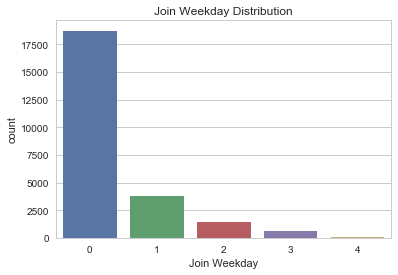

In [331]:
#Plot join_weekday to view distribution
sns.countplot(df['join_weekday'])
plt.xlabel('Join Weekday')
plt.title('Join Weekday Distribution')
plt.show()

#### Join Date

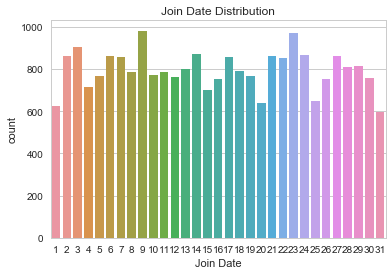

In [332]:
#Plot join_date to view distribution
sns.countplot(df['join_day'])
plt.xlabel('Join Date')
plt.title('Join Date Distribution')
plt.show()

#### Quit Date - Feature Extraction

In [333]:
#Extract info from quit date to observe trends
df['quit_year']=df.quit_date.dt.year
df['quit_month']=df.quit_date.dt.month
df['quit_day']=df.quit_date.dt.day
df['quit_week']=df.quit_date.dt.week
df['quit_weekday']=df.quit_date.dt.weekday

#### Quit Year

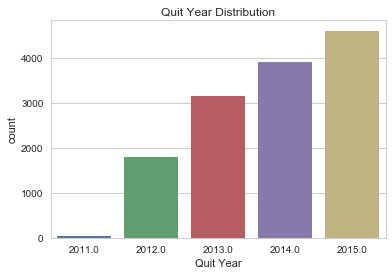

In [334]:
#Plot quit_year to view distribution
sns.countplot(df['quit_year'])
plt.xlabel('Quit Year')
plt.title('Quit Year Distribution')
plt.show()

#### Quit Month

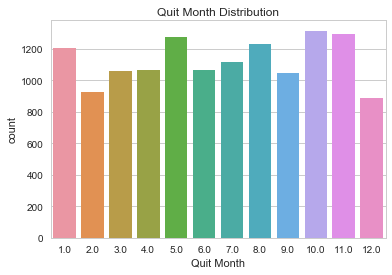

In [335]:
#Plot quit_month to view distribution
sns.countplot(df['quit_month'])
plt.xlabel('Quit Month')
plt.title('Quit Month Distribution')
plt.show()

In [336]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_year,join_month,join_day,join_week,join_weekday,quit_year,quit_month,quit_day,quit_week,quit_weekday
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,2014,3,24,13,0,2015.0,10.0,30.0,44.0,4.0
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,2013,4,29,18,0,2014.0,4.0,4.0,14.0,4.0
2,927315,4,marketing,14,101000.0,2014-10-13,NaT,2014,10,13,42,0,NaN,NaN,NaN,NaN,NaN
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,2012,5,14,20,0,2013.0,6.0,7.0,23.0,4.0
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,2011,10,17,42,0,2014.0,8.0,22.0,34.0,4.0


#### Quit Week

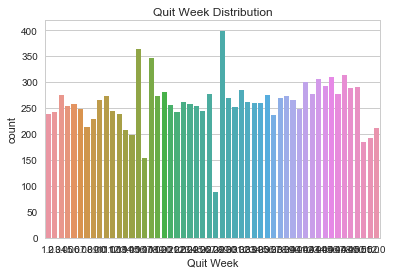

In [337]:
#Plot quit_week to view distribution
sns.countplot(df['quit_week'])
plt.xlabel('Quit Week')
plt.title('Quit Week Distribution')
plt.show()

#### Quit Weekday

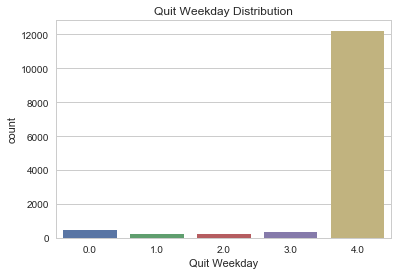

In [338]:
#Plot quit_weekday to view distribution
sns.countplot(df['quit_weekday'])
plt.xlabel('Quit Weekday')
plt.title('Quit Weekday Distribution')
plt.show()

#### Quit Day

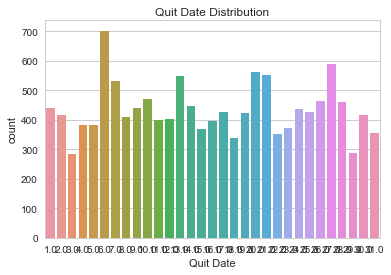

In [339]:
#Plot quit_day to view distribution
sns.countplot(df['quit_day'])
plt.xlabel('Quit Date')
plt.title('Quit Date Distribution')
plt.show()

### Feature Engineering

#### Create Employee Headcount table

Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate
employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13.
That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have
already quit, then company headcount on 2012/03/02 for company 1 would be 1000.
You should create a table with 3 columns: day, employee_headcount, company_id.

In [340]:
dates =np.unique(pd.date_range(start='1/24/2011',end='12/13/2015', freq='D'))
company_id=np.unique(df['company_id'])

In [341]:
day=[]
company=[]
emp_headcount=[]
for i in dates:
    for j in company_id:
        sub_df=df[(df.join_date<=i)&(df.company_id==j)&((df.quit_date>i))]
        day.append(i)
        company.append(j)
        emp_headcount.append((sub_df.shape[0]))

In [342]:
headcount_df=pd.DataFrame()
headcount_df['day']=pd.DataFrame(day)
headcount_df['company']=pd.DataFrame(company)
headcount_df['emp_headcount']=pd.DataFrame(emp_headcount)

In [343]:
headcount_df.head()

,day,company,emp_headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


In [344]:
df = pd.merge(df, headcount_df, how='left', left_on=['company_id','quit_date'], right_on = ['company','day'])

In [345]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_year,join_month,join_day,join_week,join_weekday,quit_year,quit_month,quit_day,quit_week,quit_weekday,day,company,emp_headcount
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,2014,3,24,13,0,2015.0,10.0,30.0,44.0,4.0,2015-10-30,7.0,27.0
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,2013,4,29,18,0,2014.0,4.0,4.0,14.0,4.0,2014-04-04,7.0,322.0
2,927315,4,marketing,14,101000.0,2014-10-13,NaT,2014,10,13,42,0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,2012,5,14,20,0,2013.0,6.0,7.0,23.0,4.0,2013-06-07,7.0,371.0
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,2011,10,17,42,0,2014.0,8.0,22.0,34.0,4.0,2014-08-22,2.0,920.0


#### Calculate Days of Employment

In [346]:
#Days of employment
df['days_employed']=(df['quit_date']-df['join_date']).dt.days

In [347]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_year,join_month,join_day,...,join_weekday,quit_year,quit_month,quit_day,quit_week,quit_weekday,day,company,emp_headcount,days_employed
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,2014,3,24,...,0,2015.0,10.0,30.0,44.0,4.0,2015-10-30,7.0,27.0,585.0
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,2013,4,29,...,0,2014.0,4.0,4.0,14.0,4.0,2014-04-04,7.0,322.0,340.0
2,927315,4,marketing,14,101000.0,2014-10-13,NaT,2014,10,13,...,0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,2012,5,14,...,0,2013.0,6.0,7.0,23.0,4.0,2013-06-07,7.0,371.0,389.0
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,2011,10,17,...,0,2014.0,8.0,22.0,34.0,4.0,2014-08-22,2.0,920.0,1040.0


### Identify Relationships

#### Seniority Versus Salary

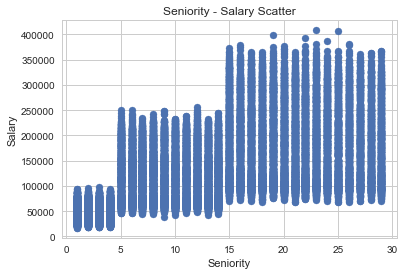

In [287]:
#Plot seniority against salary
plt.scatter(df['seniority'],df['salary'])
plt.xlabel('Seniority')
plt.ylabel('Salary')
plt.title('Seniority - Salary Scatter')
plt.show()

#### Days Employed Distribution

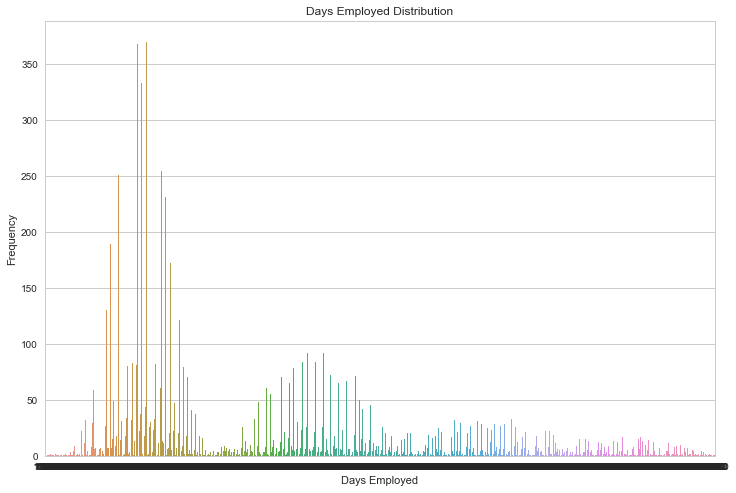

In [288]:
#Plot Days Employed Distribution
plt.figure(figsize=(12,8))
sns.countplot(df['days_employed'])
plt.xlabel('Days Employed')
plt.ylabel('Frequency')
plt.title('Days Employed Distribution')
plt.show()

#### Company ID versus Days Employed

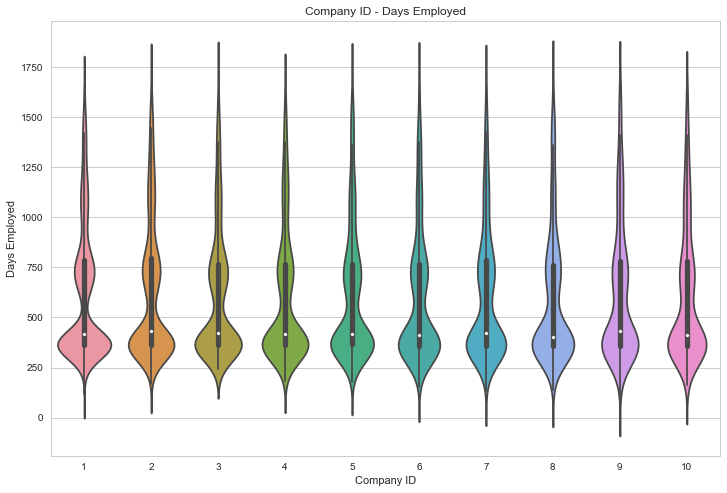

In [289]:
#Plot Company ID vs Days Employed Distribution
plt.figure(figsize=(12,8))
sns.violinplot(x=df['company_id'],y=df['days_employed'])
plt.xlabel('Company ID')
plt.ylabel('Days Employed')
plt.title('Company ID - Days Employed')
plt.show()

#### Dept versus Days Employed

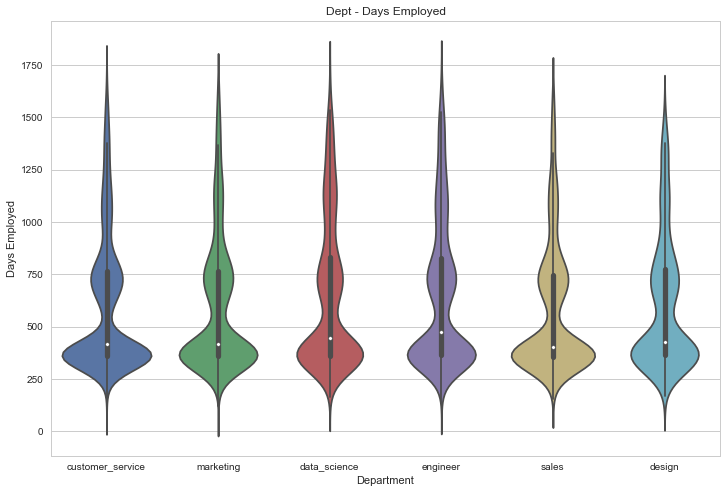

In [290]:
#Plot Dept vs Days Employed Distribution
plt.figure(figsize=(12,8))
sns.violinplot(x=df['dept'],y=df['days_employed'])
plt.xlabel('Department')
plt.ylabel('Days Employed')
plt.title('Dept - Days Employed')
plt.show()

#### Company ID versus Seniority

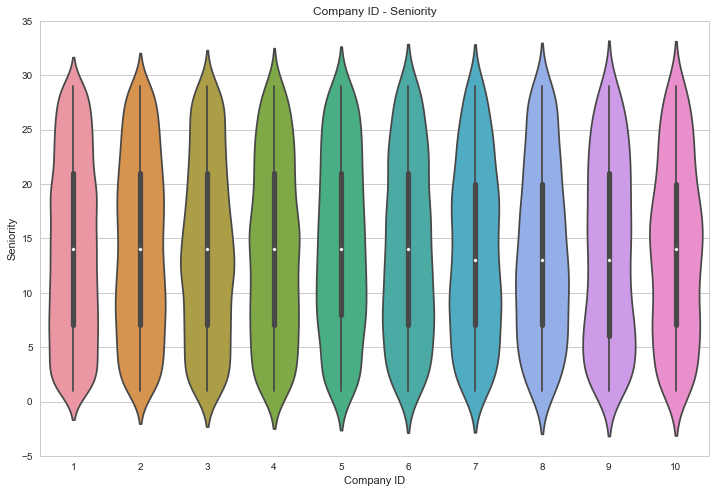

In [291]:
#Plot Company ID vs Seniority Distribution
plt.figure(figsize=(12,8))
sns.violinplot(x=df['company_id'],y=df['seniority'])
plt.xlabel('Company ID')
plt.ylabel('Seniority')
plt.title('Company ID - Seniority')
plt.show()

#### Dept versus Seniority

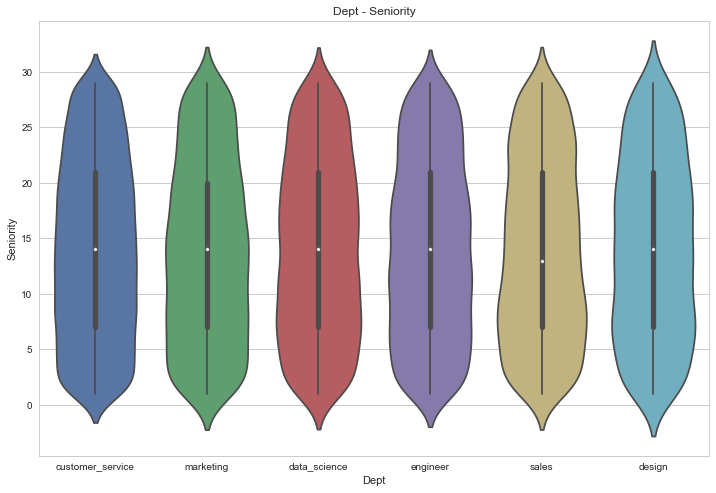

In [292]:
#Plot Dept vs Seniority Distribution
plt.figure(figsize=(12,8))
sns.violinplot(x=df['dept'],y=df['seniority'])
plt.xlabel('Dept')
plt.ylabel('Seniority')
plt.title('Dept - Seniority')
plt.show()

#### Dept, Seniority, Company ID

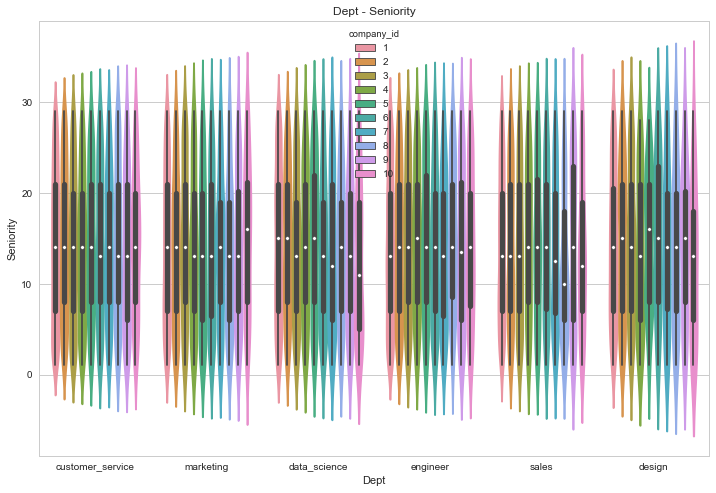

In [293]:
#Plot Dept vs Seniority Distribution
plt.figure(figsize=(12,8))
sns.violinplot(x=df['dept'],y=df['seniority'],hue=df['company_id'])
plt.xlabel('Dept')
plt.ylabel('Seniority')
plt.title('Dept - Seniority')
plt.show()

#### Create Target Variable - Churned versus Employed

In [294]:
#Recode Churned employees as 1 and employed employees as 0
df['churned'] = df['quit_date'].apply(lambda x : True if pd.notnull(x) else False)

#### Calculate Correlation

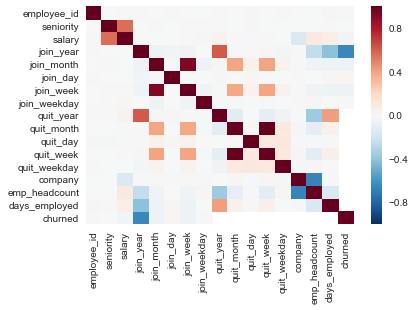

In [295]:
#Calculate correlation
correlation=df.corr()
sns.heatmap(correlation)

#### Classification Models - Data Prep

In [296]:
df=df.drop(['join_date','quit_date','day','company','employee_id','join_weekday','quit_weekday','quit_year','quit_month','quit_week','quit_day','emp_headcount','days_employed'],axis=1)

In [297]:
df=df.drop(['join_day','join_week'],axis=1)

In [298]:
df.head()

,company_id,dept,seniority,salary,join_year,join_month,churned
0,7,customer_service,28,89000.0,2014,3,True
1,7,marketing,20,183000.0,2013,4,True
2,4,marketing,14,101000.0,2014,10,False
3,7,customer_service,20,115000.0,2012,5,True
4,2,data_science,23,276000.0,2011,10,True


In [299]:
df['join_year']=df['join_year'].astype(object)
df['join_month']=df['join_month'].astype(object)

In [300]:
df=pd.get_dummies(df)
df=df.drop(['join_year_2011','join_month_1','company_id_1','dept_sales'],axis=1)

In [301]:
X,y=df.drop('churned',axis=1),df['churned']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [302]:
X.head()

,seniority,salary,company_id_2,company_id_3,company_id_4,company_id_5,company_id_6,company_id_7,company_id_8,company_id_9,...,join_month_3,join_month_4,join_month_5,join_month_6,join_month_7,join_month_8,join_month_9,join_month_10,join_month_11,join_month_12
0,28,89000.0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,20,183000.0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,14,101000.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,20,115000.0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,23,276000.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [303]:
#Apply Standard Scaler
stdsc=StandardScaler()
X_train=stdsc.fit_transform(X_train)
X_test=stdsc.transform(X_test)

In [304]:
#Run Random Forest to Review Feature Importances
feat_labels=X.columns
forest=RandomForestClassifier(criterion='entropy',n_estimators=10,random_state=10,n_jobs=2)
forest.fit(X_train,y_train)
importances=forest.feature_importances_
indices=np.argsort(importances[::-1])
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1,30,feat_labels[indices[f]],importances[indices[f]]))

 1) salary                         0.231066
 2) join_year_2013                 0.024792
 3) join_month_4                   0.007824
 4) join_month_5                   0.007969
 5) join_month_3                   0.008152
 6) join_month_2                   0.007744
 7) join_year_2014                 0.065893
 8) company_id_10                  0.007389
 9) company_id_8                   0.006898
10) company_id_7                   0.006925
11) join_month_6                   0.008915
12) company_id_9                   0.007248
13) company_id_4                   0.009724
14) seniority                      0.165367
15) join_year_2015                 0.262190
16) join_month_7                   0.010340
17) company_id_6                   0.008055
18) company_id_3                   0.010031
19) company_id_2                   0.016628
20) join_year_2012                 0.031199
21) join_month_8                   0.008260
22) join_month_9                   0.009082
23) company_id_5                

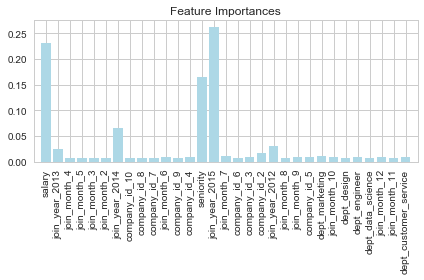

In [305]:
#Plot Feature Importances
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),importances[indices],color='lightblue',align='center')
plt.xticks(range(X_train.shape[1]),feat_labels[indices],rotation=90)
plt.xlim([-1,X_train.shape[1]])
plt.tight_layout()
plt.show()

#### Compare Algorithms

In [306]:
num_folds=10
num_instances=len(X_train)
seed=7

In [307]:
models=[]
models.append(('LR',LogisticRegression()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('SVM',SVC()))

In [308]:
results=[]
names=[]
scoring='accuracy'
for name, model in models:
    kfold=KFold(n=num_instances,n_folds=num_folds,random_state=seed)
    cv_results=cross_val_score(model,X_train,y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg="%s: %f (%f)" % (name,cv_results.mean(),cv_results.std())
    print(msg)

LR: 0.792433 (0.006483)
KNN: 0.741687 (0.009445)
CART: 0.724191 (0.010335)
SVM: 0.795330 (0.008266)


#### Support Vector Machines

In [309]:
svm=SVC()
svm.fit(X_train,y_train)
y_pred=svm.predict(X_test)
print("Accuracy : ",accuracy_score(y_pred,y_test))
print("Precision : ",precision_score(y_pred,y_test))
print("Recall : ",recall_score(y_pred,y_test))
print("F1 Score : ",f1_score(y_pred,y_test))
print("ROC_AUC_Score : ",roc_auc_score(y_pred,y_test))
print("Confusion Matrix : ",confusion_matrix(y_pred,y_test))

Accuracy :  0.7933225196
Precision :  0.847099311701
Recall :  0.791637950839
F1 Score :  0.818430115188
ROC_AUC_Score :  0.793684328457
Confusion Matrix :  [[2423  622]
 [ 907 3446]]
